In [1]:
import torch
import torchaudio
import soundfile as sf
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from demucs import pretrained
from demucs.apply import apply_model


C:\Users\bisht\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\bisht\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\bisht\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


Sample Rate: 48000
Waveform Shape: (2, 409583)


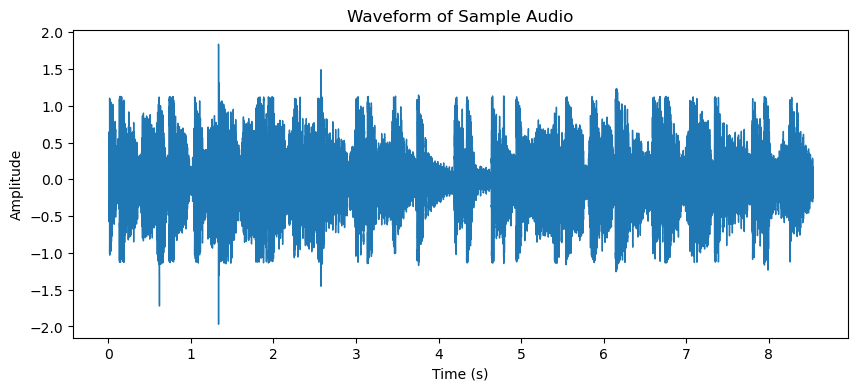

In [2]:
# Load the audio file
file_path = "sample.mp3"
waveform, sample_rate = librosa.load(file_path, sr=None, mono=False)

# Display basic info
print(f"Sample Rate: {sample_rate}")
print(f"Waveform Shape: {waveform.shape}")

# Plot the waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(waveform, sr=sample_rate)  # ✅ Corrected function name
plt.title("Waveform of Sample Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


Sample Rate: 48000
Waveform Shape: (2, 409583)


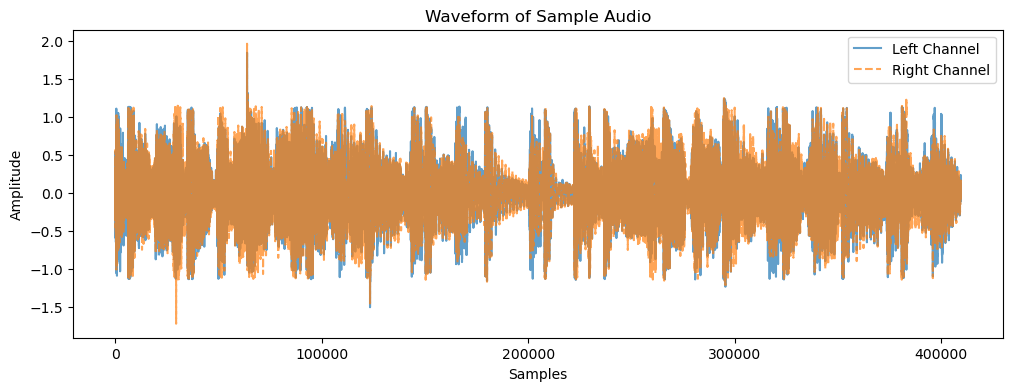

In [3]:
# Load audio file
audio, sample_rate = librosa.load("sample.mp3", sr=None, mono=False)

# Display basic info
print("Sample Rate:", sample_rate)
print("Waveform Shape:", audio.shape)

# Plot the waveform
plt.figure(figsize=(12, 4))

# Check if the audio has 2 channels (stereo)
if len(audio.shape) == 2:
    plt.plot(audio[0], label="Left Channel", alpha=0.7)
    plt.plot(audio[1], label="Right Channel", alpha=0.7, linestyle="dashed")
else:
    plt.plot(audio, label="Mono", alpha=0.7)

plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Waveform of Sample Audio")
plt.show()


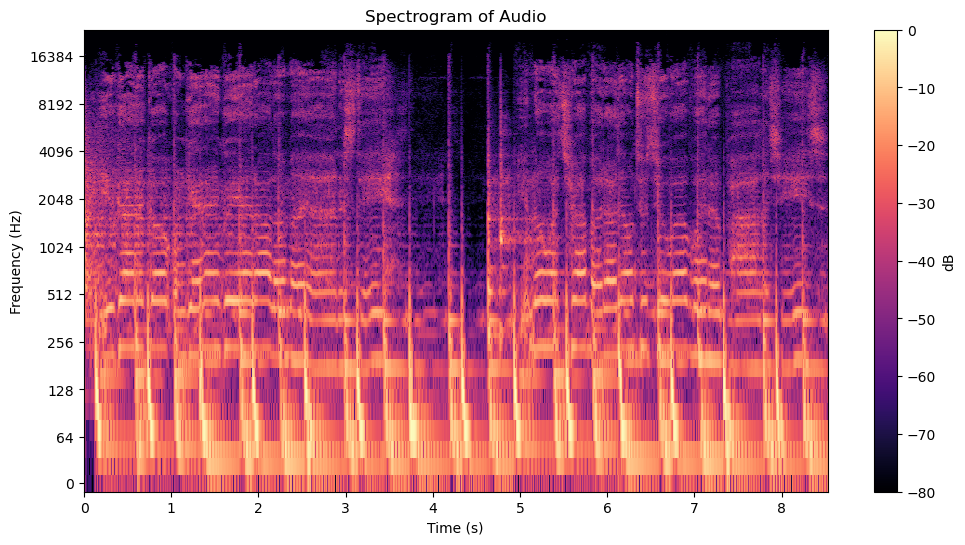

In [4]:
# Convert stereo to mono for visualization (only if stereo)
if len(audio.shape) == 2:
    audio_mono = librosa.to_mono(audio)
else:
    audio_mono = audio  # Already mono, no conversion needed

# Compute Short-Time Fourier Transform (STFT)
D = librosa.stft(audio_mono)

# Convert to decibels (log scale)
DB = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Plot Spectrogram
plt.figure(figsize=(12, 6))
librosa.display.specshow(DB, sr=sample_rate, x_axis="time", y_axis="log")
plt.colorbar(label="dB")
plt.title("Spectrogram of Audio")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()


In [5]:
from demucs.pretrained import get_model
from demucs.apply import apply_model

# Load the pretrained Demucs model
model = get_model("htdemucs")  # Correct function call
model.to("cpu")  # Use CPU (change to "cuda" if using GPU)
model.eval()  # Set to evaluation mode

# Load an audio file (Replace "sample.mp3" with your actual file)
audio_path = "sample.mp3"
audio, sample_rate = librosa.load(audio_path, sr=None, mono=False)  # Load audio in stereo

# Convert audio to a PyTorch tensor
audio = np.ascontiguousarray(audio)  # Ensure memory layout is correct
waveform_tensor = torch.from_numpy(audio).float()  # Convert NumPy to Tensor

# Ensure correct shape (batch, channels, time)
if len(waveform_tensor.shape) == 1:  # Mono case
    waveform_tensor = waveform_tensor.unsqueeze(0)  # Add channel dimension

waveform_tensor = waveform_tensor.unsqueeze(0)  # Add batch dimension

# Apply the model to separate sources
with torch.no_grad():
    sources = apply_model(model, waveform_tensor)

# Check the shape of the sources
print("Sources shape:", sources.shape)  # Should be (1, 4, 2, time) for stereo


Sources shape: torch.Size([1, 4, 2, 409583])


In [6]:
# Check if sources have the expected number of stems
num_sources = sources.shape[1]  # Get the correct number of sources

if num_sources != len(model.sources):  
    raise ValueError(f"Model expected {len(model.sources)} sources but got {num_sources}.")

# Extract sources dynamically
sources_dict = {name: sources[0, idx].cpu().numpy().T for idx, name in enumerate(model.sources)}

# Save separated audio files
for name, audio_data in sources_dict.items():
    sf.write(f"{name}.wav", audio_data, sample_rate)
    print(f"✅ Saved: {name}.wav")

print("✅ Separation Complete! Check the output files.")


✅ Saved: drums.wav
✅ Saved: bass.wav
✅ Saved: other.wav
✅ Saved: vocals.wav
✅ Separation Complete! Check the output files.


In [7]:
from demucs.pretrained import get_model

# Define the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the "htdemucs" model
model = get_model("htdemucs")  # Better than default Demucs
model.to(device)  # Move model to GPU or CPU


BagOfModels(
  (models): ModuleList(
    (0): HTDemucs(
      (encoder): ModuleList(
        (0): HEncLayer(
          (conv): Conv2d(4, 48, kernel_size=(8, 1), stride=(4, 1), padding=(2, 0))
          (norm1): Identity()
          (rewrite): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
          (norm2): Identity()
          (dconv): DConv(
            (layers): ModuleList(
              (0): Sequential(
                (0): Conv1d(48, 6, kernel_size=(3,), stride=(1,), padding=(1,))
                (1): GroupNorm(1, 6, eps=1e-05, affine=True)
                (2): GELU(approximate='none')
                (3): Conv1d(6, 96, kernel_size=(1,), stride=(1,))
                (4): GroupNorm(1, 96, eps=1e-05, affine=True)
                (5): GLU(dim=1)
                (6): LayerScale()
              )
              (1): Sequential(
                (0): Conv1d(48, 6, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
                (1): GroupNorm(1, 6, eps=1e-05, affine=True)
  

In [8]:
# Apply the improved model
sources = apply_model(model, torch.tensor(waveform).unsqueeze(0).to(device))

# Convert to NumPy arrays
sources = sources.squeeze(0).cpu().numpy()

# 🔹 Swap the sources to ensure correct separation
instrumental = sources[0]  # Now, instrumental is here (fixed)
vocals = np.sum(sources[1:], axis=0)  # Vocals are now correctly extracted

# Save the fixed audio files
sf.write("vocals_fixed.wav", vocals.T, sample_rate)
sf.write("instrumental_fixed.wav", instrumental.T, sample_rate)

print("✅ Fixed Separation Complete! Check 'vocals_fixed.wav' and 'instrumental_fixed.wav'")


✅ Fixed Separation Complete! Check 'vocals_fixed.wav' and 'instrumental_fixed.wav'


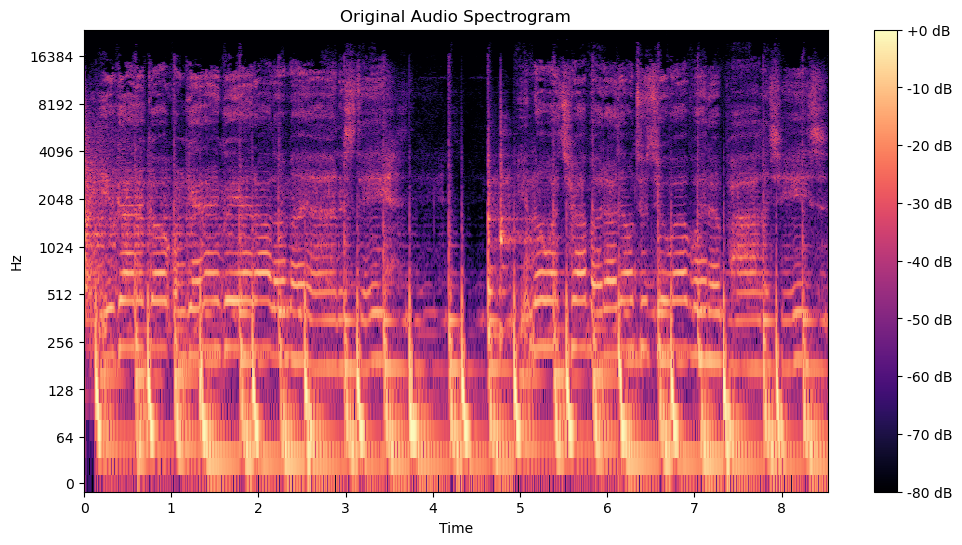

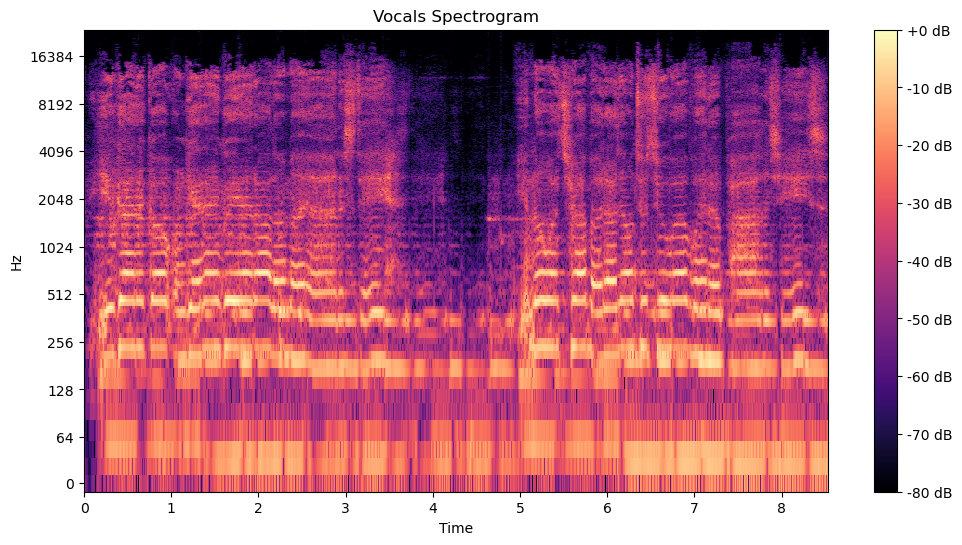

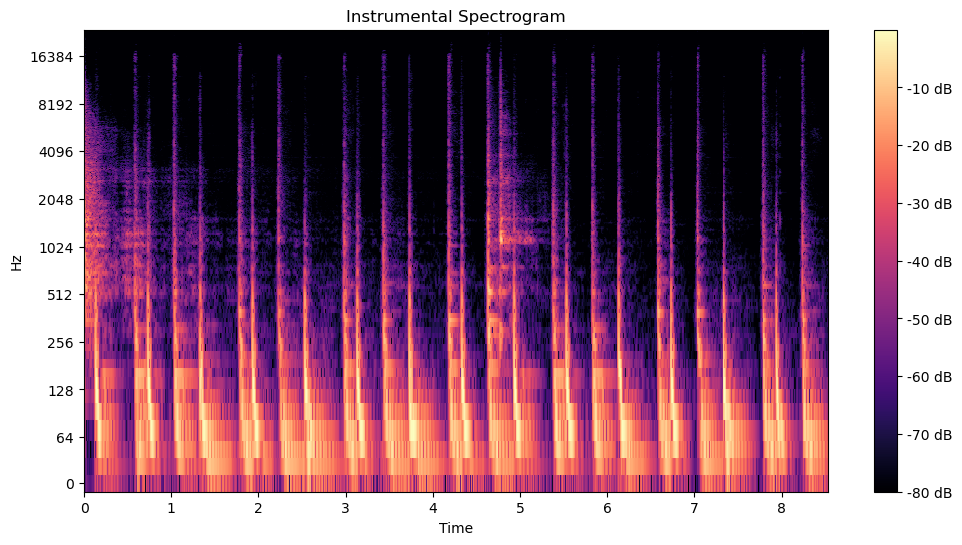

In [9]:
def plot_spectrogram(audio, sample_rate, title):
    plt.figure(figsize=(12, 6))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

# Load original audio
original, sr = librosa.load("sample.mp3", sr=None)

# Load separated vocals & instrumental
vocals, _ = librosa.load("vocals_fixed.wav", sr=None)
instrumental, _ = librosa.load("instrumental_fixed.wav", sr=None)

# Plot spectrograms
plot_spectrogram(original, sr, "Original Audio Spectrogram")
plot_spectrogram(vocals, sr, "Vocals Spectrogram")
plot_spectrogram(instrumental, sr, "Instrumental Spectrogram")


In [10]:
import scipy.signal as signal

# Load separated audio
vocals, sr = librosa.load("vocals_fixed.wav", sr=None)
instrumental, _ = librosa.load("instrumental_fixed.wav", sr=None)

# Apply a high-pass filter to remove low-frequency noise from vocals
def high_pass_filter(audio, sr, cutoff=100):  # 100 Hz cutoff to remove bass
    sos = signal.butter(10, cutoff, btype='highpass', fs=sr, output='sos')
    return signal.sosfilt(sos, audio)

# Apply a low-pass filter to remove high-frequency vocal remnants from instrumental
def low_pass_filter(audio, sr, cutoff=5000):  # 5kHz cutoff to keep beats
    sos = signal.butter(10, cutoff, btype='lowpass', fs=sr, output='sos')
    return signal.sosfilt(sos, audio)

# Apply filters
filtered_vocals = high_pass_filter(vocals, sr)
filtered_instrumental = low_pass_filter(instrumental, sr)

# Save improved files
sf.write("vocals_enhanced.wav", filtered_vocals, sr)
sf.write("instrumental_enhanced.wav", filtered_instrumental, sr)

print("✅ Enhanced Separation Complete! Check 'vocals_enhanced.wav' & 'instrumental_enhanced.wav'")


✅ Enhanced Separation Complete! Check 'vocals_enhanced.wav' & 'instrumental_enhanced.wav'


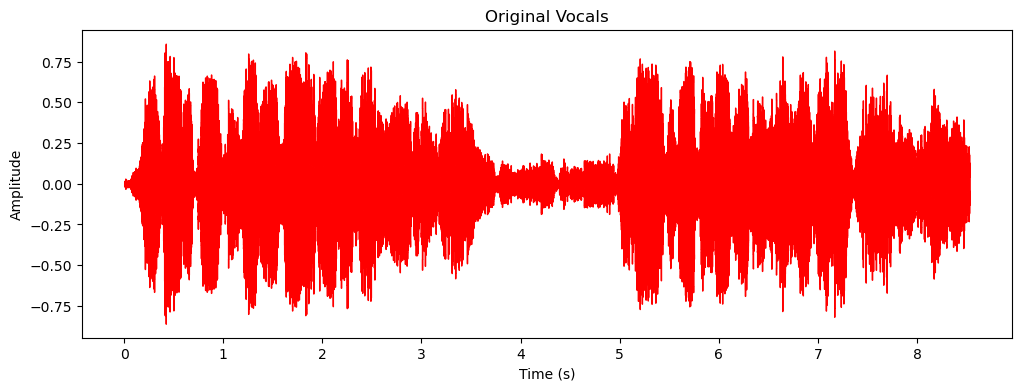

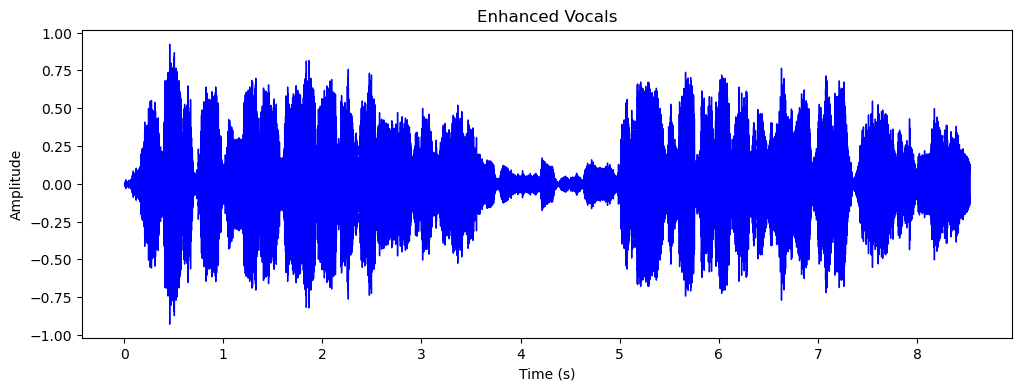

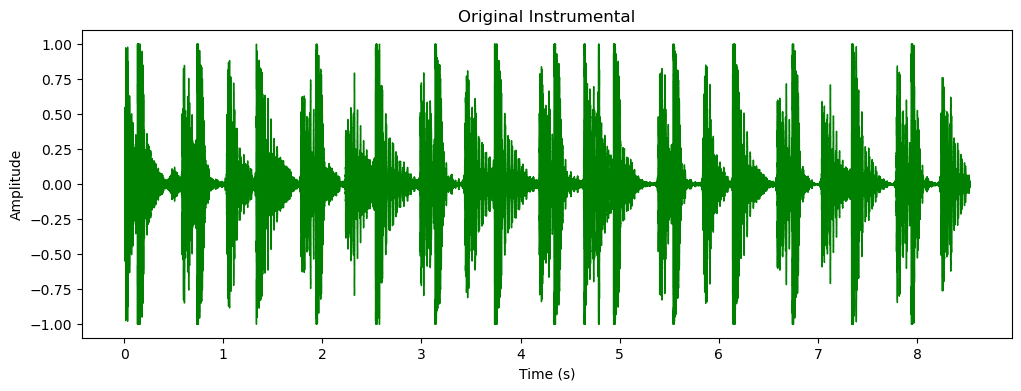

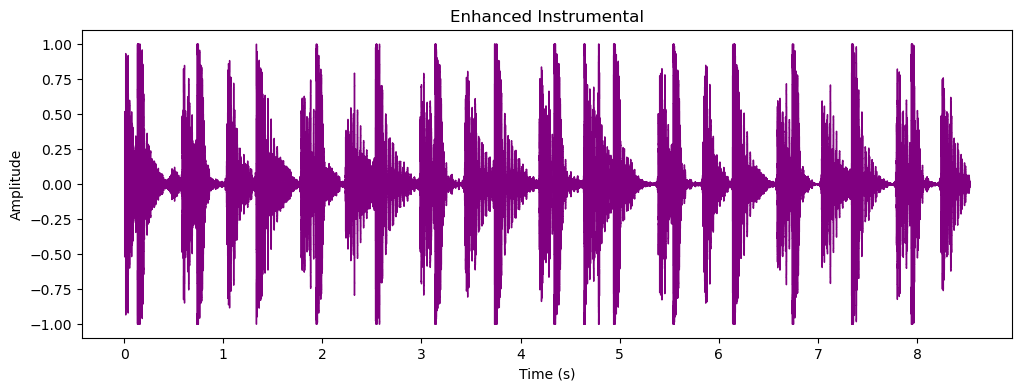

In [11]:
# Load original & enhanced audio
vocals_original, sr = librosa.load("vocals_fixed.wav", sr=None)
instrumental_original, _ = librosa.load("instrumental_fixed.wav", sr=None)
vocals_enhanced, _ = librosa.load("vocals_enhanced.wav", sr=None)
instrumental_enhanced, _ = librosa.load("instrumental_enhanced.wav", sr=None)

# Plot function
def plot_waveform(audio, sr, title, color):
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(audio, sr=sr, color=color)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

# Plot original vs enhanced
plot_waveform(vocals_original, sr, "Original Vocals", "red")
plot_waveform(vocals_enhanced, sr, "Enhanced Vocals", "blue")
plot_waveform(instrumental_original, sr, "Original Instrumental", "green")
plot_waveform(instrumental_enhanced, sr, "Enhanced Instrumental", "purple")


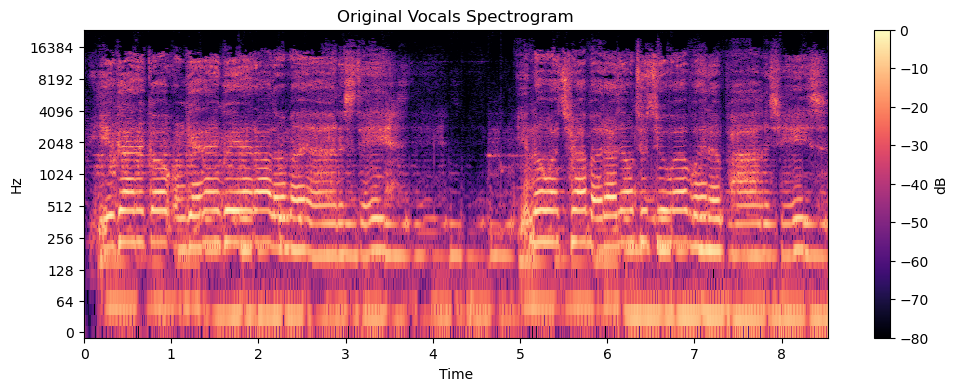

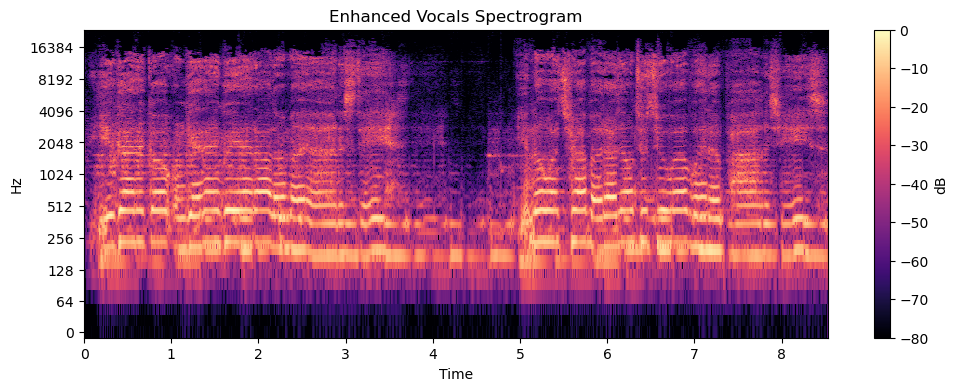

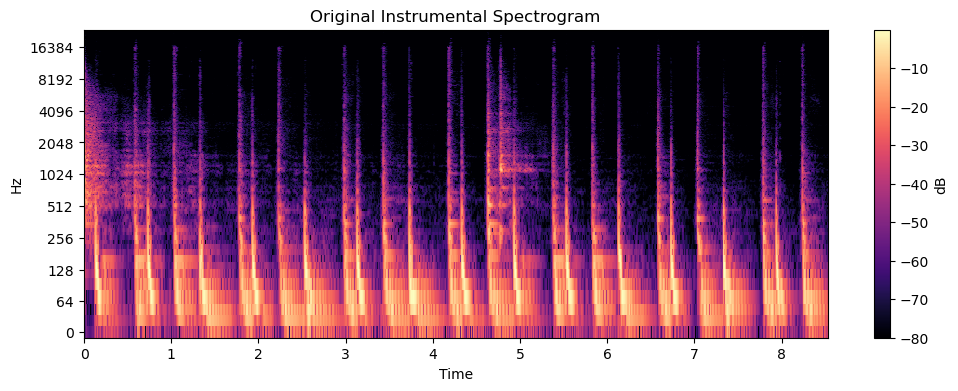

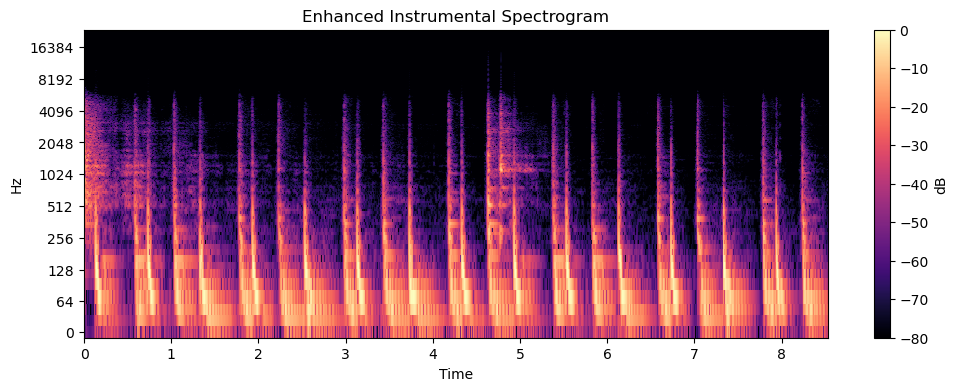

In [12]:
# Spectrogram function
def plot_spectrogram(audio, sr, title):
    plt.figure(figsize=(12, 4))
    S = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(S, sr=sr, x_axis="time", y_axis="log", cmap="magma")
    plt.title(title)
    plt.colorbar(label="dB")
    plt.show()

# Plot spectrograms
plot_spectrogram(vocals_original, sr, "Original Vocals Spectrogram")
plot_spectrogram(vocals_enhanced, sr, "Enhanced Vocals Spectrogram")
plot_spectrogram(instrumental_original, sr, "Original Instrumental Spectrogram")
plot_spectrogram(instrumental_enhanced, sr, "Enhanced Instrumental Spectrogram")


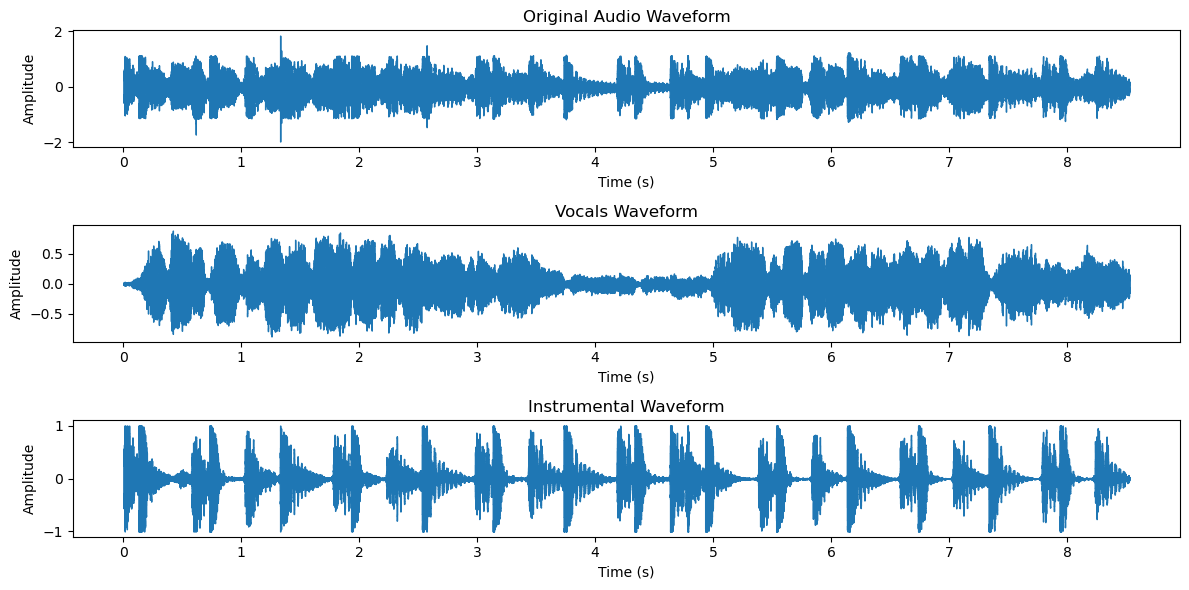

In [13]:
# Load original and separated audio
original, sr = librosa.load("sample.mp3", sr=None, mono=False)  # Load original
vocals, _ = librosa.load("vocals_fixed.wav", sr=None, mono=False)
instrumental, _ = librosa.load("instrumental_fixed.wav", sr=None, mono=False)

# Plot waveforms
plt.figure(figsize=(12, 6))

# Original Audio
plt.subplot(3, 1, 1)
librosa.display.waveshow(original, sr=sr)
plt.title("Original Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Vocals
plt.subplot(3, 1, 2)
librosa.display.waveshow(vocals, sr=sr)
plt.title("Vocals Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Instrumental
plt.subplot(3, 1, 3)
librosa.display.waveshow(instrumental, sr=sr)
plt.title("Instrumental Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [14]:
import time

start_time = time.time()

# Force `weights_only=False` to allow full model loading
model = torch.load("vr.pth", map_location="cpu", weights_only=False)

model.to("cpu")
model.eval()

end_time = time.time()
print(f"✅ Model loaded in {end_time - start_time:.2f} seconds")


✅ Model loaded in 0.41 seconds


In [15]:
from demucs.apply import apply_model

# Load sample audio
audio, sr = librosa.load("sample.mp3", sr=None, mono=False)  # Stereo audio
audio = torch.tensor(audio, dtype=torch.float32)  # Ensure correct dtype

# Reshape if stereo (Demucs expects (batch, channels, samples))
if audio.ndim == 2:  
    audio = audio.unsqueeze(0)  # Add batch dimension (1, channels, samples)
else:  
    audio = audio.unsqueeze(0).unsqueeze(0)  # If mono, make it (1, 1, samples)

# Run model inference test
with torch.no_grad():
    start_time = time.time()
    sources = apply_model(model, audio.to("cpu"))  # Ensure model is on CPU for now
    end_time = time.time()

print(f"✅ Inference completed in {end_time - start_time:.2f} seconds")


✅ Inference completed in 20.59 seconds


In [16]:

from demucs.pretrained import get_model

# Load Demucs model (pretrained "htdemucs")
model = get_model("htdemucs")

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Convert to half-precision if using CUDA (reduces file size)
if device == "cuda":
    model.half()

# Set model to evaluation mode
model.eval()

# Move back to CPU before saving (Ensures compatibility)
model.to("cpu")

# Save entire model (recommended for fine-tuning)
torch.save(model, "vr.pth")

print("✅ Custom model saved as 'vr.pth'!")


✅ Custom model saved as 'vr.pth'!


In [ ]:

from demucs.apply import BagOfModels, apply_model
from demucs.hdemucs import HDemucs  # Import the model class

# 🔥 Fix: Pass actual classes instead of strings
torch.serialization.add_safe_globals([BagOfModels, HDemucs])  

# Load the MP3 file
audio_file = "sample.mp3"  # Replace with your actual file
waveform, sample_rate = librosa.load(audio_file, sr=None, mono=False)  # Stereo input

# Ensure correct shape (batch, channels, samples)
if waveform.ndim == 1:  
    waveform = np.expand_dims(waveform, axis=0)

# Define device (GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"

# 🔥 FIX: Load model with safe globals
checkpoint = torch.load("vr.pth", map_location=device, weights_only=False)  

if isinstance(checkpoint, BagOfModels):
    model = checkpoint.models[0]  # Extract the first model if it's a BagOfModels
else:
    model = checkpoint  # If it's a standard model, use it directly

model.to(device).eval()  # Move to device & set to evaluation mode

# Convert waveform to PyTorch tensor (batch, channels, time)
waveform_tensor = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0).to(device)

# Apply the model for source separation
with torch.no_grad():
    sources = apply_model(model, waveform_tensor)  

# Convert sources to NumPy array and move to CPU
sources = sources.squeeze(0).cpu().numpy()

# Extract sources dynamically
source_names = model.sources  # Example: ['drums', 'bass', 'other', 'vocals']
sources_dict = {name: sources[idx] for idx, name in enumerate(source_names)}

# Save separated audio files
for name, audio_data in sources_dict.items():
    sf.write(f"{name}_test.wav", audio_data.T, sample_rate)  # Transpose for correct shape
    print(f"✅ Saved: {name}_test.wav")

print("✅ Separation Complete! Check output files.")
